# Human-Mammalian Brain Basal Ganglia 10X snRANSeq analysis: clustering and annotations

[Intro text]

You need to be connected to the internet to run this notebook or connected to a cache that has the HMBA-BG data downloaded already.

The notebook presented here shows quick visualizations from precomputed metadata in the atlas. For examples on accessing the expression matrices, specifically selecting genes from expression matrices, see the  ``general_acessing_10x_snRNASeq_tutorial.ipynb`` tutorial/example.

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import anndata
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
test_data_base = Path('/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/hmba_bg_prep')
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest

'releases/20250331/manifest.json'

## Data overview
### Cell metadata

Essential cell metadata is stored as a CSV file that we load as a Pandas DataFrme. Each row represents one cell indexed by a *cell label*. The *cell label* is the concatenation of barcode and name of the sample. In this context, the sample is the *barcoded cell sample* that represents a single load into one port of the 10x Chromium. Note that cell barcodes are only unique within a single *barcoded cell sample* and that the same barcode can be reused. The *barcoded cell sample* label or name is unique in the database. This metadata file contains cells across all species in the HMBA-BG dataset.

Each cell is associated with a *library label*, *donor label*, *alignment_job_id*, *feature_matrix_label* and *dataset_label* identifying which data package this cell is part of. This metadata file will be combined with other metadata files that ship with this package to add information associated with the donor, UMAP coordinates, cluster assignments, and more.

Below, we load the first of the metadata used in this tutorial. This pattern of loading metadata is repeated throughout the tutorials.

In [3]:
# abc_cache.list_metadata_files('HMBA-10xMultiome-BG')

In [4]:
# abc_cache.list_metadata_files('HMBA-taxonomy-BG')

In [5]:
cell = pd.read_csv(
    test_data_base / "HMBA-10xMultiome-BG/metadata/cell_metadata.csv",
    dtype={'cell_label': str}
)

"""
cell = abc_cache.get_metadata_dataframe(
    directory='WHB-10Xv3',
    file_name='cell_metadata',
    dtype={'cell_label': str}
)
"""
cell.set_index('cell_label', inplace=True)
print("Number of cells = ", len(cell))
cell.head()

/tmp/ipykernel_10956/321481536.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  cell = pd.read_csv(


Number of cells =  2936782


cell_barcode donor_label  \
cell_label                                                
AAACAGCCAAATGCCC-2362_A05  AAACAGCCAAATGCCC  H24.30.001   
AAACAGCCAATTGAGA-2362_A05  AAACAGCCAATTGAGA  H24.30.001   
AAACAGCCAGCATGTC-2362_A05  AAACAGCCAGCATGTC  H24.30.001   
AAACAGCCATTGACAT-2362_A05  AAACAGCCATTGACAT  H24.30.001   
AAACAGCCATTGTGGC-2362_A05  AAACAGCCATTGTGGC  H24.30.001   

                          barcoded_cell_sample_label       library_label  \
cell_label                                                                 
AAACAGCCAAATGCCC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAATTGAGA-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAGCATGTC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGACAT-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGTGGC-2362_A05                   2362_A05  L8XR_240808_01_E02   

                                                   alignment_job_id  \
cell_label                                                            
AAACAGCCAAATGCCC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAATTGAGA-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAGCATGTC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGACAT-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGTGGC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   

                           doublet_score  umi_count  \
cell_label                                            
AAACAGCCAAATGCCC-2362_A05       0.027027    15259.0   
AAACAGCCAATTGAGA-2362_A05       0.054795    20645.0   
AAACAGCCAGCATGTC-2362_A05       0.000000     2551.0   
AAACAGCCATTGACAT-2362_A05       0.000000     2341.0   
AAACAGCCATTGTGGC-2362_A05       0.027397     8326.0   

                                feature_matrix_label        dataset_label  
cell_label                                                                 
AAACAGCCAAATGCCC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG  
AAACAGCCAATTGAGA-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG  
AAACAGCCAGCATGTC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG  
AAACAGCCATTGACAT-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG  
AAACAGCCATTGTGGC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG

We can use pandas groupby function to see how many unique items are associated for each field and list them out if the number of items is small.

In [6]:
def print_column_info(df):
    
    for c in df.columns:
        grouped = df[[c]].groupby(c).count()
        members = ''
        if len(grouped) < 30:
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c, len(grouped), members))

In [7]:
print_column_info(cell)

Number of unique cell_barcode = 722176 
Number of unique donor_label = 22 ['CJ23.56.002', 'CJ23.56.003', 'CJ24.56.001', 'CJ24.56.004', 'H18.30.001', 'H19.30.004', 'H20.30.001', 'H20.30.002', 'H21.30.004', 'H23.30.001', 'H24.30.001', 'H24.30.003', 'H24.30.004', 'H24.30.007', 'Q19.26.010', 'Q21.26.002', 'Q21.26.010', 'QM21.26.001', 'QM21.26.003', 'QM23.50.001', 'QM23.50.002', 'QM23.50.003']
Number of unique barcoded_cell_sample_label = 417 
Number of unique library_label = 417 
Number of unique alignment_job_id = 303 
Number of unique doublet_score = 2581 
Number of unique umi_count = 120559 
Number of unique feature_matrix_label = 3 ['HMBA-10xMultiome-BG-Human', 'HMBA-10xMultiome-BG-Macaque', 'HMBA-10xMultiome-BG-Marmoset']
Number of unique dataset_label = 1 ['HMBA-10xMultiome-BG']


Below we use a pandas group by to show the number of cells from each feature matrix. This shows the number of cells from each species in the HMBA Basal Ganglia dataset.

In [8]:
cell.groupby('feature_matrix_label')[['donor_label']].count()

donor_label
feature_matrix_label                     
HMBA-10xMultiome-BG-Human         1683105
HMBA-10xMultiome-BG-Macaque        839102
HMBA-10xMultiome-BG-Marmoset       414575

### Donor and Library metadata

The first two associated metadata we load are the `donor` and `library` tables. The donor table contains species, sex, and age information. The library table contains information on 10X methods and brain region of interest the tissue was extracted from.

In [9]:
donor = pd.read_csv(
    test_data_base / "HMBA-10xMultiome-BG/metadata/donor.csv",
).set_index('donor_label')
donor.head()

donor_species species_scientific_name species_common_name  \
donor_label                                                               
QM23.50.003  NCBITaxon:9544          Macaca mulatta             Macaque   
QM21.26.001  NCBITaxon:9544          Macaca mulatta             Macaque   
Q19.26.010   NCBITaxon:9544          Macaca mulatta             Macaque   
H24.30.003   NCBITaxon:9606            Homo sapiens               Human   
H21.30.004   NCBITaxon:9606            Homo sapiens               Human   

            donor_sex donor_age  donor_age_value donor_age_unit  
donor_label                                                      
QM23.50.003      Male     6 yrs              6.0          years  
QM21.26.001      Male     6 yrs              6.0          years  
Q19.26.010     Female    10 yrs             10.0          years  
H24.30.003     Female    19 yrs             19.0          years  
H21.30.004       Male    57 yrs             57.0          years

In [10]:
library = pd.read_csv(
    test_data_base / "HMBA-10xMultiome-BG/metadata/library.csv",
).set_index('library_label')
library.head()

library_method barcoded_cell_sample_label  \
library_label                                                    
L8XR_240222_21_H03  10xMultiome;GEX                   2077_A02   
L8XR_220428_02_A05  10xMultiome;GEX                   1224_A04   
L8XR_220428_02_C04  10xMultiome;GEX                   1222_A02   
L8XR_240705_01_A06  10xMultiome;GEX                   2305_E01   
L8XR_240919_21_B05  10xMultiome;GEX                   2453_A02   

                                            enrichment_population  \
library_label                                                       
L8XR_240222_21_H03              50% NeuN+, 35% OLIG2-, 15% OLIG2+   
L8XR_220428_02_A05  10% NeuN+, 49% OLIG2-, 25% OLIG2+, 16% Nurr1+   
L8XR_220428_02_C04              60% NeuN+, 27% OLIG2-, 13% OLIG2+   
L8XR_240705_01_A06              50% NeuN+, 35% OLIG2-, 15% OLIG2+   
L8XR_240919_21_B05              70% NeuN+, 20% OLIG2-, 10% OLIG2+   

                   cell_specimen_type parcellation_term_identifier  \
library_label                                                        
L8XR_240222_21_H03             Nuclei                   DHBA:11538   
L8XR_220428_02_A05             Nuclei                   DHBA:12261   
L8XR_220428_02_C04             Nuclei                   DHBA:10466   
L8XR_240705_01_A06             Nuclei                   DHBA:11537   
L8XR_240919_21_B05             Nuclei                   DHBA:10345   

                   region_of_interest_name region_of_interest_label  \
library_label                                                         
L8XR_240222_21_H03          caudal putamen                      PuC   
L8XR_220428_02_A05  ventral tegmental area                      VTA   
L8XR_220428_02_C04     subthalamic nucleus                      STH   
L8XR_240705_01_A06         rostral putamen                      PuR   
L8XR_240919_21_B05        Ventral pallidus                      VeP   

                   anatomical_division_label  donor_label  
library_label                                              
L8XR_240222_21_H03             Basal ganglia  QM23.50.003  
L8XR_220428_02_A05             Basal ganglia  QM21.26.001  
L8XR_220428_02_C04             Basal ganglia   Q19.26.010  
L8XR_240705_01_A06             Basal ganglia   H24.30.003  
L8XR_240919_21_B05             Basal ganglia   H21.30.004

We combine these into an extended cell metadata table.

In [11]:
cell_extended = cell.join(donor, on='donor_label')
cell_extended = cell_extended.join(library, on='library_label', rsuffix='_library_table')

### Adding color and feature order

Each feature in the donor and library table comes is associated with unique colors and an ordering with the set of values. Below we load the mapping and incorporate these values into the cell metadata table. 

In [12]:
value_sets = pd.read_csv(
    test_data_base / "extracted/value_sets.csv"
).set_index('label')
value_sets.head()

table                field description  order external_identifier  \
label                                                                         
Female    donor            donor_sex      Female      1                 NaN   
Male      donor            donor_sex        Male      2                 NaN   
Human     donor  species_common_name       Human      1                 NaN   
Macaque   donor  species_common_name     Macaque      2                 NaN   
Marmoset  donor  species_common_name    Marmoset      3                 NaN   

         parent_label color_hex_triplet comment  
label                                            
Female            NaN           #565353     NaN  
Male              NaN           #ADC4C3     NaN  
Human             NaN           #377eb8     NaN  
Macaque           NaN           #4daf4a     NaN  
Marmoset          NaN           #FF5F5D     NaN

In [13]:
# Add region of interest color and order.
cell_extended['region_of_interest_label_color'] = value_sets[
    value_sets['table'] == 'library'
].loc[cell_extended['region_of_interest_label']]['color_hex_triplet'].values
cell_extended['region_of_interest_label_order'] = value_sets[
    value_sets['table'] == 'library'
].loc[cell_extended['region_of_interest_label']]['order'].values

# Add speices scientific name color and order.
cell_extended['species_scientific_name_color'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_scientific_name']]['color_hex_triplet'].values
cell_extended['species_scientific_name_order'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_scientific_name']]['order'].values

# Add speices common name color and order.
cell_extended['species_common_name_color'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_common_name']]['color_hex_triplet'].values
cell_extended['species_common_name_order'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_common_name']]['order'].values

# Add donor sex color and order.
cell_extended['donor_sex_color'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['donor_sex']]['color_hex_triplet'].values
cell_extended['donor_sex_order'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['donor_sex']]['order'].values
cell_extended.head()

cell_barcode donor_label  \
cell_label                                                
AAACAGCCAAATGCCC-2362_A05  AAACAGCCAAATGCCC  H24.30.001   
AAACAGCCAATTGAGA-2362_A05  AAACAGCCAATTGAGA  H24.30.001   
AAACAGCCAGCATGTC-2362_A05  AAACAGCCAGCATGTC  H24.30.001   
AAACAGCCATTGACAT-2362_A05  AAACAGCCATTGACAT  H24.30.001   
AAACAGCCATTGTGGC-2362_A05  AAACAGCCATTGTGGC  H24.30.001   

                          barcoded_cell_sample_label       library_label  \
cell_label                                                                 
AAACAGCCAAATGCCC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAATTGAGA-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAGCATGTC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGACAT-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGTGGC-2362_A05                   2362_A05  L8XR_240808_01_E02   

                                                   alignment_job_id  \
cell_label                                                            
AAACAGCCAAATGCCC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAATTGAGA-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAGCATGTC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGACAT-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGTGGC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   

                           doublet_score  umi_count  \
cell_label                                            
AAACAGCCAAATGCCC-2362_A05       0.027027    15259.0   
AAACAGCCAATTGAGA-2362_A05       0.054795    20645.0   
AAACAGCCAGCATGTC-2362_A05       0.000000     2551.0   
AAACAGCCATTGACAT-2362_A05       0.000000     2341.0   
AAACAGCCATTGTGGC-2362_A05       0.027397     8326.0   

                                feature_matrix_label        dataset_label  \
cell_label                                                                  
AAACAGCCAAATGCCC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCAATTGAGA-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCAGCATGTC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCATTGACAT-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCATTGTGGC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   

                            donor_species  ... anatomical_division_label  \
cell_label                                 ...                             
AAACAGCCAAATGCCC-2362_A05  NCBITaxon:9606  ...             Basal ganglia   
AAACAGCCAATTGAGA-2362_A05  NCBITaxon:9606  ...             Basal ganglia   
AAACAGCCAGCATGTC-2362_A05  NCBITaxon:9606  ...             Basal ganglia   
AAACAGCCATTGACAT-2362_A05  NCBITaxon:9606  ...             Basal ganglia   
AAACAGCCATTGTGGC-2362_A05  NCBITaxon:9606  ...             Basal ganglia   

                          donor_label_library_table  \
cell_label                                            
AAACAGCCAAATGCCC-2362_A05                H24.30.001   
AAACAGCCAATTGAGA-2362_A05                H24.30.001   
AAACAGCCAGCATGTC-2362_A05                H24.30.001   
AAACAGCCATTGACAT-2362_A05                H24.30.001   
AAACAGCCATTGTGGC-2362_A05                H24.30.001   

                          region_of_interest_label_color  \
cell_label                                                 
AAACAGCCAAATGCCC-2362_A05                        #A845EA   
AAACAGCCAATTGAGA-2362_A05                        #A845EA   
AAACAGCCAGCATGTC-2362_A05                        #A845EA   
AAACAGCCATTGACAT-2362_A05                        #A845EA   
AAACAGCCATTGTGGC-2362_A05                        #A845EA   

                          region_of_interest_label_order  \
cell_label                                                 
AAACAGCCAAATGCCC-2362_A05                             14   
AAACAGCCAATTGAGA-2362_A05                             14   
AAACAGCCAGCATGTC-2362_A05                             14   
AAACAGCCATTGACAT-236

### UMAP spatial embedding

Now that we've merged our donor and library metadata into the main cells data, our next step is to put these values in a Uniform Manifold Approximation and Projection (UMAP) for cells in the dataset. The UMAP is a dimension reduction technique that can be used for visualizing and exploring large-dimension datasets. 

Below we load this 2-D embedding for a sub selection of our cells and merge the x-y coordinates into the extended cell metadata we are creating. 

In [14]:
cell_2d_embedding_coordinates = pd.read_csv(
    test_data_base / "HMBA-BG-taxonomy-CCN20250428/cell_2d_embedding_coordinates.csv"
).set_index('cell_label')
cell_2d_embedding_coordinates.head()

x          y
cell_label                                     
AAACAGCCAAATGCCC-2362_A05   2.070891  -9.649055
AAACAGCCAATTGAGA-2362_A05  15.948389  -3.659716
AAACAGCCAGCATGTC-2362_A05   6.668315 -10.659956
AAACAGCCATTGACAT-2362_A05  11.499167  -2.078146
AAACAGCCATTGTGGC-2362_A05  13.769540   8.967738

In [15]:
cell_extended = cell_extended.join(cell_2d_embedding_coordinates)

In [16]:
cell_extended = cell_extended.sample(frac=1)

We define a small helper function *plot umap* to visualize the cells on the UMAP. In the examples below we will plot associated cell information colorized by dissection donor species, sex, and region of interest.

In [17]:
def plot_umap(
    xx,
    yy,
    cc=None,
    val=None,
    fig_width=8,
    fig_height=8,
    cmap=None,
    labels=None,
    term_orders=None,
    colorbar=False,
    sizes=None
):
    """
    """
    if sizes is None:
        sizes = 1
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None:
        scatt = ax.scatter(xx, yy, c=val, s=0.5, marker='.', cmap=cmap, alpha=sizes)
    elif cc is not None:
        scatt = ax.scatter(xx, yy, c=cc, s=0.5, marker='.', alpha=sizes)

    if labels is not None:
        from matplotlib.patches import Rectangle
        unique_label_colors = (labels + ',' + cc).unique()
        unique_labels = np.array([label_color.split(',')[0] for label_color in unique_label_colors])
        unique_colors = np.array([label_color.split(',')[1] for label_color in unique_label_colors])

        if term_orders is not None:
            unique_order = term_orders.unique()
            term_order = np.argsort(unique_order)
            unique_labels = unique_labels[term_order]
            unique_colors = unique_colors[term_order]
            
        rects = []
        for color in unique_colors:
            rects.append(Rectangle((0, 0), 1, 1, fc=color))

        legend = ax.legend(rects, unique_labels, loc=1)
        # ax.add_artist(legend)

    if colorbar:
        fig.colorbar(scatt, ax=ax)
    
    return fig, ax

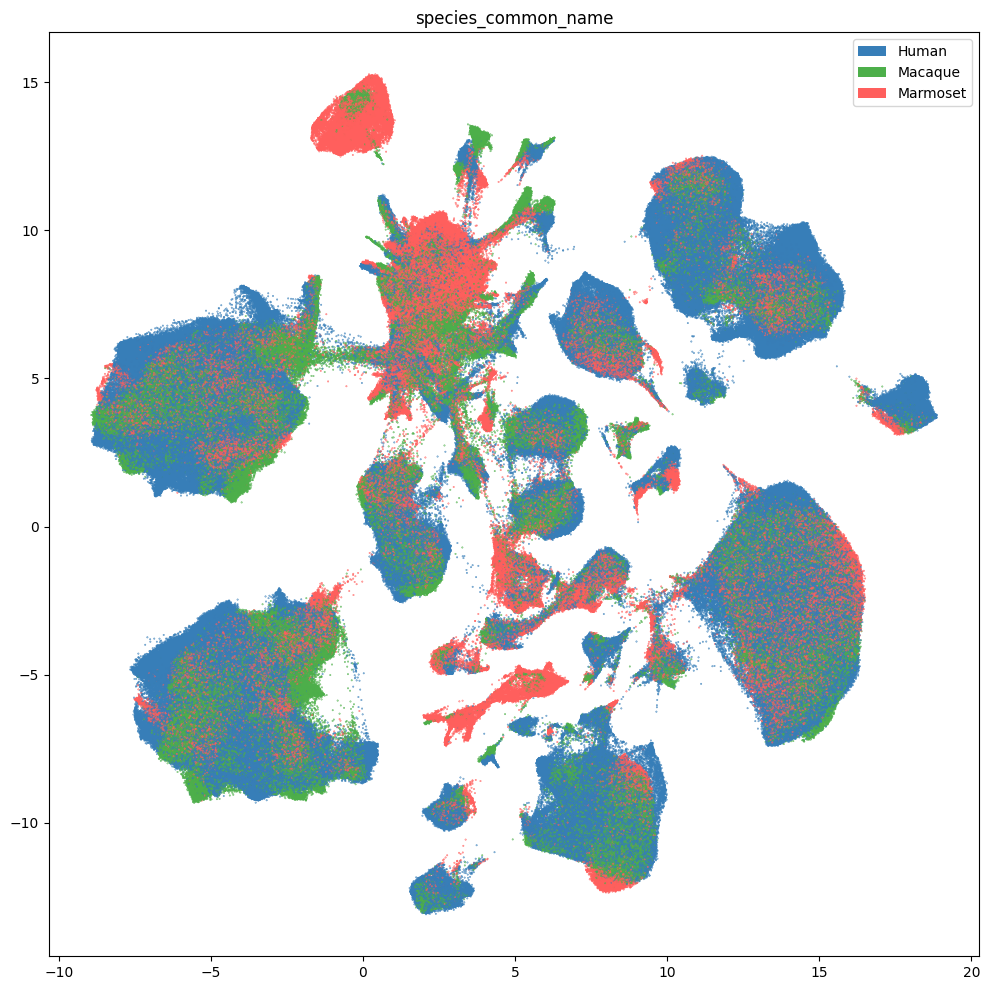

In [18]:
cell_with_umap = cell_extended[~pd.isna(cell_extended['x'])]
fig, ax = plot_umap(
    cell_with_umap['x'],
    cell_with_umap['y'],
    cc=cell_with_umap['species_common_name_color'],
    labels=cell_with_umap['species_common_name'],
    term_orders=cell_with_umap['species_common_name_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("species_common_name")
plt.show()

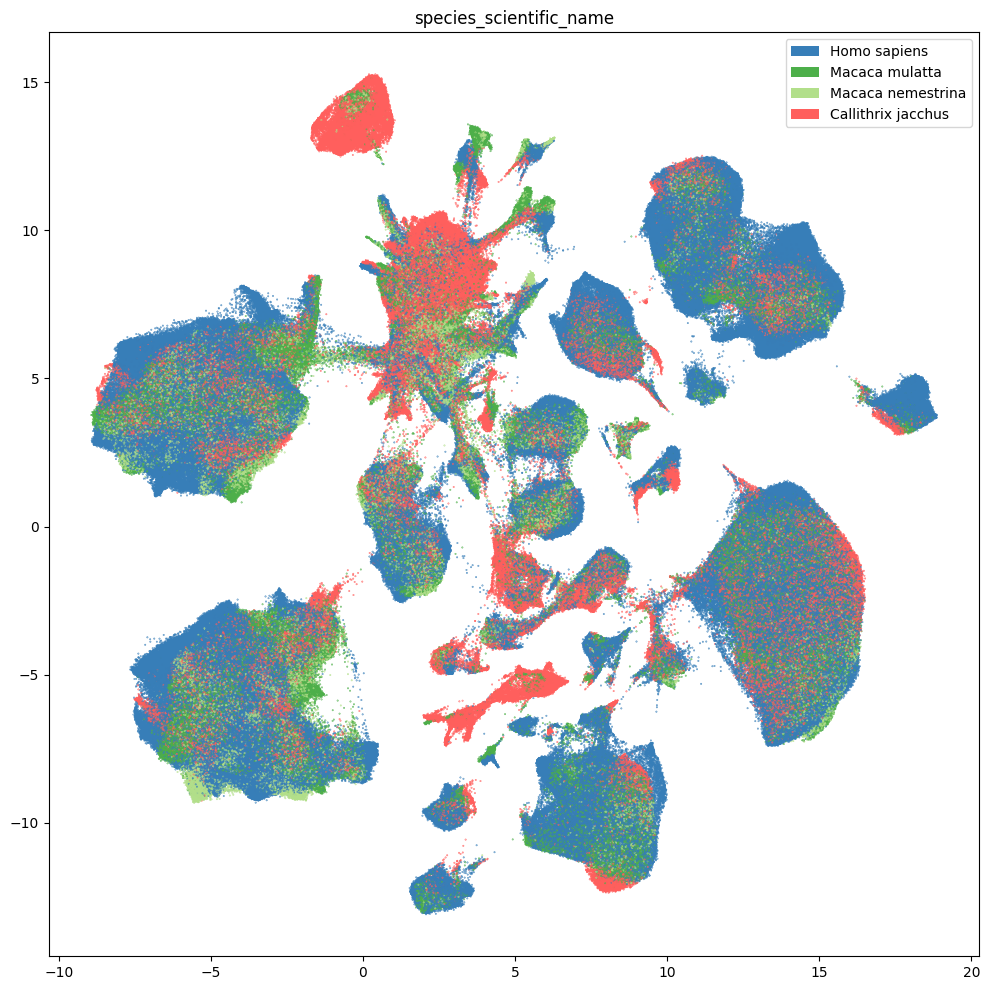

In [19]:
fig, ax = plot_umap(
    cell_with_umap['x'],
    cell_with_umap['y'],
    cc=cell_with_umap['species_scientific_name_color'],
    labels=cell_with_umap['species_scientific_name'],
    term_orders=cell_with_umap['species_scientific_name_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("species_scientific_name")
plt.show()

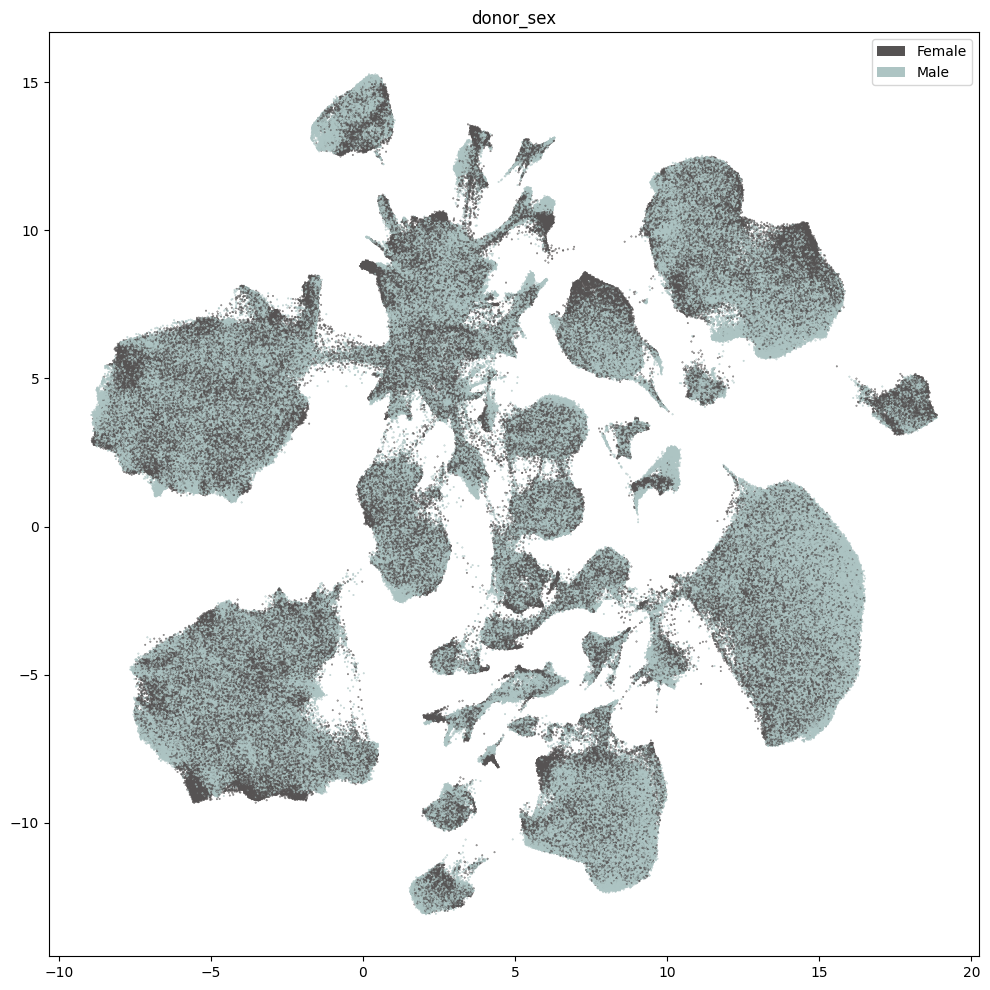

In [20]:
fig, ax = plot_umap(
    cell_with_umap['x'],
    cell_with_umap['y'],
    cc=cell_with_umap['donor_sex_color'],
    labels=cell_with_umap['donor_sex'],
    term_orders=cell_with_umap['donor_sex_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("donor_sex")
plt.show()

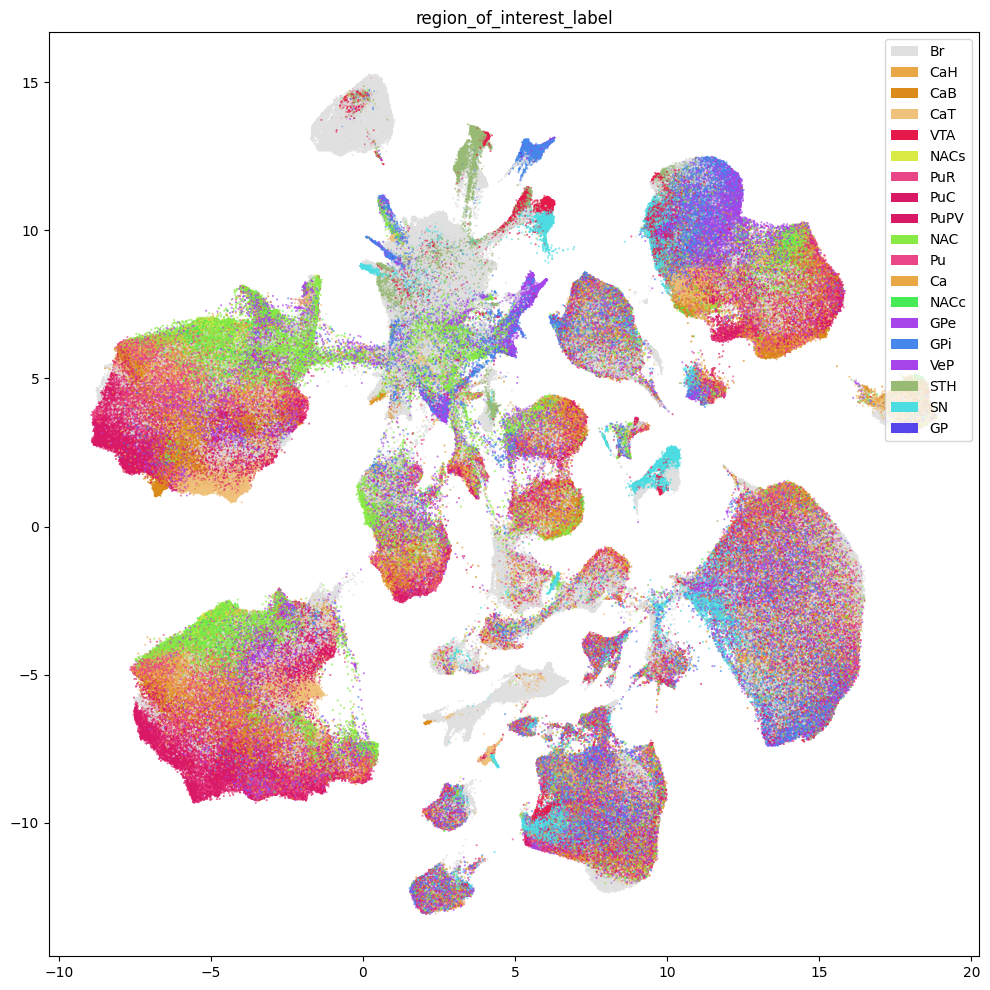

In [21]:
fig, ax = plot_umap(
    cell_with_umap['x'],
    cell_with_umap['y'],
    cc=cell_with_umap['region_of_interest_label_color'],
    labels=cell_with_umap['region_of_interest_label'],
    term_orders=cell_with_umap['region_of_interest_label_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("region_of_interest_label")
plt.show()

## Taxonomy Information

The final set of metadata we load into our extended cell metadata file maps the cells into their assigned cluster in the taxonomy. We additionally load metadata regarding the clusters and compute useful information, such as the number of cells in each taxon at each level of the taxonomy.

First, we load the table that describes the levels in the taxonomy from Neighborhood at the highest to Cluster at the lowest level.

In [22]:
cluster_annotation_term_set = pd.read_csv(
    test_data_base / "HMBA-BG-taxonomy-CCN20250428/cluster_annotation_term_set.csv"
).rename(columns={'label': 'cluster_annotation_term_label'})
cluster_annotation_term_set

cluster_annotation_term_label          name   description  order
0           CCN20250428_LEVEL_0  Neighborhood  Neighborhood      0
1           CCN20250428_LEVEL_1         Class         Class      1
2           CCN20250428_LEVEL_2      Subclass      Subclass      2
3           CCN20250428_LEVEL_3         Group         Group      3
4           CCN20250428_LEVEL_4       Cluster       Cluster      4

Next, we load information associated with each Cluster in the taxonomy. This includes a useful alias value for each cluster as well as the number of cells in each cluster.

In [23]:
cluster = pd.read_csv(
    test_data_base / "HMBA-BG-taxonomy-CCN20250428/cluster.csv",
    dtype={'number_of_cells': 'Int64'}
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
cluster.head()

cluster_alias  number_of_cells
cluster_annotation_term_label                               
CS20250428_CLUST_0161             Human-143               91
CS20250428_CLUST_0162             Human-145             1783
CS20250428_CLUST_0163             Human-146              172
CS20250428_CLUST_0164             Human-149             2649
CS20250428_CLUST_0165             Human-150             1359

Finally, for the clusters, we load information on the annotations for each cluster. This also includes the term order and color information which we will use to plot later.

In [24]:
cluster_annotation_term = pd.read_csv(
    test_data_base / "HMBA-BG-taxonomy-CCN20250428/cluster_annotation_term.csv"
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
cluster_annotation_term.head()

name  \
cluster_annotation_term_label                         
CS20250428_NEIGH_0001                     Nonneuron   
CS20250428_NEIGH_0000                Glut Sero Dopa   
CS20250428_NEIGH_0002               Subpallium GABA   
CS20250428_NEIGH_0003          Subpallium GABA-Glut   
CS20250428_CLASS_0000                    Astro-Epen   

                              cluster_annotation_term_set_label  \
cluster_annotation_term_label                                     
CS20250428_NEIGH_0001                       CCN20250428_LEVEL_0   
CS20250428_NEIGH_0000                       CCN20250428_LEVEL_0   
CS20250428_NEIGH_0002                       CCN20250428_LEVEL_0   
CS20250428_NEIGH_0003                       CCN20250428_LEVEL_0   
CS20250428_CLASS_0000                       CCN20250428_LEVEL_1   

                              cluster_annotation_term_set_name  \
cluster_annotation_term_label                                    
CS20250428_NEIGH_0001                             Neighborhood   
CS20250428_NEIGH_0000                             Neighborhood   
CS20250428_NEIGH_0002                             Neighborhood   
CS20250428_NEIGH_0003                             Neighborhood   
CS20250428_CLASS_0000                                    Class   

                              color_hex_triplet  term_order  term_set_order  \
cluster_annotation_term_label                                                 
CS20250428_NEIGH_0001                   #f2ca7d           1               0   
CS20250428_NEIGH_0000                   #91f4bb           2               0   
CS20250428_NEIGH_0002                   #19613b           3               0   
CS20250428_NEIGH_0003                   #7e1d19           4               0   
CS20250428_CLASS_0000                   #6ec0da           1               1   

                                   parent_term_label parent_term_name  \
cluster_annotation_term_label                                           
CS20250428_NEIGH_0001                            NaN              NaN   
CS20250428_NEIGH_0000                            NaN              NaN   
CS20250428_NEIGH_0002                            NaN              NaN   
CS20250428_NEIGH_0003                            NaN              NaN   
CS20250428_CLASS_0000          CS20250428_NEIGH_0001        Nonneuron   

                              parent_term_set_label  
cluster_annotation_term_label                        
CS20250428_NEIGH_0001                           NaN  
CS20250428_NEIGH_0000                           NaN  
CS20250428_NEIGH_0002                           NaN  
CS20250428_NEIGH_0003                           NaN  
CS20250428_CLASS_0000           CCN20250428_LEVEL_0

We merge this table with information from our clusters.

In [25]:
cluster_annotation_term_with_cells = cluster_annotation_term.join(cluster)

While we have information on the number of cells in each cluster, we need to sum these to get the number of cells in each of the upper levels of the taxonomy. Below we iterate through each level from the lowest to highest, summing the number of cells as we go.

In [26]:
for cluster_annotation_term_label in reversed(sorted(cluster_annotation_term_with_cells['cluster_annotation_term_set_label'].unique())):
    sub_terms = cluster_annotation_term_with_cells[
        cluster_annotation_term_with_cells['cluster_annotation_term_set_label'] == cluster_annotation_term_label
    ]
    parents = sub_terms['parent_term_label'].unique()
    if np.any(pd.isna(sub_terms['number_of_cells'])):
            print("Warning nan values:", sub_terms[pd.isna(sub_terms['number_of_cells'])].index)
            sub_terms
    for parent in parents:
        if pd.isna(parent):
            continue
        n_cells = sub_terms[
            sub_terms['parent_term_label'] == parent
        ]['number_of_cells'].sum()
        cluster_annotation_term_with_cells.loc[parent, 'number_of_cells'] = n_cells
    
cluster_annotation_term_with_cells['number_of_cells'].fillna(0, inplace=True)
cluster_annotation_term_with_cells.head()

Warning nan values: Index(['CS20250428_GROUP_0061'], dtype='object', name='cluster_annotation_term_label')


/tmp/ipykernel_10956/398396013.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cluster_annotation_term_with_cells['number_of_cells'].fillna(0, inplace=True)


name  \
cluster_annotation_term_label                         
CS20250428_NEIGH_0001                     Nonneuron   
CS20250428_NEIGH_0000                Glut Sero Dopa   
CS20250428_NEIGH_0002               Subpallium GABA   
CS20250428_NEIGH_0003          Subpallium GABA-Glut   
CS20250428_CLASS_0000                    Astro-Epen   

                              cluster_annotation_term_set_label  \
cluster_annotation_term_label                                     
CS20250428_NEIGH_0001                       CCN20250428_LEVEL_0   
CS20250428_NEIGH_0000                       CCN20250428_LEVEL_0   
CS20250428_NEIGH_0002                       CCN20250428_LEVEL_0   
CS20250428_NEIGH_0003                       CCN20250428_LEVEL_0   
CS20250428_CLASS_0000                       CCN20250428_LEVEL_1   

                              cluster_annotation_term_set_name  \
cluster_annotation_term_label                                    
CS20250428_NEIGH_0001                             Neighborhood   
CS20250428_NEIGH_0000                             Neighborhood   
CS20250428_NEIGH_0002                             Neighborhood   
CS20250428_NEIGH_0003                             Neighborhood   
CS20250428_CLASS_0000                                    Class   

                              color_hex_triplet  term_order  term_set_order  \
cluster_annotation_term_label                                                 
CS20250428_NEIGH_0001                   #f2ca7d           1               0   
CS20250428_NEIGH_0000                   #91f4bb           2               0   
CS20250428_NEIGH_0002                   #19613b           3               0   
CS20250428_NEIGH_0003                   #7e1d19           4               0   
CS20250428_CLASS_0000                   #6ec0da           1               1   

                                   parent_term_label parent_term_name  \
cluster_annotation_term_label                                           
CS20250428_NEIGH_0001                            NaN              NaN   
CS20250428_NEIGH_0000                            NaN              NaN   
CS20250428_NEIGH_0002                            NaN              NaN   
CS20250428_NEIGH_0003                            NaN              NaN   
CS20250428_CLASS_0000          CS20250428_NEIGH_0001        Nonneuron   

                              parent_term_set_label cluster_alias  \
cluster_annotation_term_label                                       
CS20250428_NEIGH_0001                           NaN           NaN   
CS20250428_NEIGH_0000                           NaN           NaN   
CS20250428_NEIGH_0002                           NaN           NaN   
CS20250428_NEIGH_0003                           NaN           NaN   
CS20250428_CLASS_0000           CCN20250428_LEVEL_0           NaN   

                               number_of_cells  
cluster_annotation_term_label                   
CS20250428_NEIGH_0001                   815521  
CS20250428_NEIGH_0000                    29574  
CS20250428_NEIGH_0002                  1051965  
CS20250428_NEIGH_0003                     1021  
CS20250428_CLASS_0000                   224824

In [27]:
cluster_annotation_term_with_cells.loc['CS20250428_GROUP_0061']

name                                   THM PVALB-CLMN Glut
cluster_annotation_term_set_label      CCN20250428_LEVEL_3
cluster_annotation_term_set_name                     Group
color_hex_triplet                                  #6289f2
term_order                                              20
term_set_order                                           3
parent_term_label                    CS20250428_SUBCL_0013
parent_term_name                                    F Glut
parent_term_set_label                  CCN20250428_LEVEL_2
cluster_alias                                          NaN
number_of_cells                                          0
Name: CS20250428_GROUP_0061, dtype: object

Finally, we load the cluster to cluster annotation membership table to help us create associated metadata for each cluster to tell us the annotations for a given Cluster at all levels of the taxonomy. We'll use this in groupbys to give each cluster the metadata for each of its parents. This will be useful when we merge into the cell metadata table.

In [28]:
cluster_to_cluster_annotation_membership = pd.read_csv(
    test_data_base / "HMBA-BG-taxonomy-CCN20250428/cluster_to_cluster_annotation_membership.csv"
).set_index('cluster_annotation_term_label')
membership_with_cluster_info = cluster_to_cluster_annotation_membership.join(cluster_annotation_term_with_cells, rsuffix='_anno_term').reset_index()
"""
cluster_to_cluster_annotation_membership = abc_cache.get_metadata_dataframe(
    directory='WHB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership'
)"""
membership_groupby = membership_with_cluster_info.groupby(
    ['cluster_alias', 'cluster_annotation_term_set_name']
)
membership_with_cluster_info.head()

cluster_annotation_term_label cluster_annotation_term_set_label  \
0         CS20250428_CLUST_0161               CCN20250428_LEVEL_4   
1         CS20250428_CLUST_0162               CCN20250428_LEVEL_4   
2         CS20250428_CLUST_0163               CCN20250428_LEVEL_4   
3         CS20250428_CLUST_0164               CCN20250428_LEVEL_4   
4         CS20250428_CLUST_0165               CCN20250428_LEVEL_4   

  cluster_alias cluster_annotation_term_set_name cluster_annotation_term_name  \
0     Human-143                          Cluster                    Human-143   
1     Human-145                          Cluster                    Human-145   
2     Human-146                          Cluster                    Human-146   
3     Human-149                          Cluster                    Human-149   
4     Human-150                          Cluster                    Human-150   

        name cluster_annotation_term_set_label_anno_term  \
0  Human-143                         CCN20250428_LEVEL_4   
1  Human-145                         CCN20250428_LEVEL_4   
2  Human-146                         CCN20250428_LEVEL_4   
3  Human-149                         CCN20250428_LEVEL_4   
4  Human-150                         CCN20250428_LEVEL_4   

  cluster_annotation_term_set_name_anno_term color_hex_triplet  term_order  \
0                                    Cluster           #4ac0ed           0   
1                                    Cluster           #8af851           1   
2                                    Cluster           #d1dd68           2   
3                                    Cluster           #95daf6           3   
4                                    Cluster           #26827e           4   

   term_set_order      parent_term_label parent_term_name  \
0               4  CS20250428_GROUP_0002     BG Astrocyte   
1               4  CS20250428_GROUP_0002     BG Astrocyte   
2               4  CS20250428_GROUP_0002     BG Astrocyte   
3               4  CS20250428_GROUP_0002     BG Astrocyte   
4               4  CS20250428_GROUP_0002     BG Astrocyte   

  parent_term_set_label cluster_alias_anno_term  number_of_cells  
0   CCN20250428_LEVEL_3               Human-143               91  
1   CCN20250428_LEVEL_3               Human-145             1783  
2   CCN20250428_LEVEL_3               Human-146              172  
3   CCN20250428_LEVEL_3               Human-149             2649  
4   CCN20250428_LEVEL_3               Human-150             1359

From the membership table, create three tables, first the name of each cluster and its parents.

In [29]:
# term_sets = abc_cache.get_metadata_dataframe(directory='WHB-taxonomy', file_name='cluster_annotation_term_set').set_index('label')
cluster_details = membership_groupby['cluster_annotation_term_name'].first().unstack()
cluster_details = cluster_details[cluster_annotation_term_set['name']] # order columns
cluster_details.fillna('Other', inplace=True)
cluster_details.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_details.head()

cluster_annotation_term_set_name    Neighborhood     Class Subclass  \
cluster_alias                                                         
Human-127                         Glut Sero Dopa  F M Glut   F Glut   
Marmoset-1130                     Glut Sero Dopa  F M Glut   F Glut   
Marmoset-1174                     Glut Sero Dopa  F M Glut   F Glut   
Marmoset-554                      Glut Sero Dopa  F M Glut   F Glut   
Human-128                         Glut Sero Dopa  F M Glut   F Glut   

cluster_annotation_term_set_name          Group        Cluster  
cluster_alias                                                   
Human-127                         BG POSTN Glut      Human-127  
Marmoset-1130                     BG POSTN Glut  Marmoset-1130  
Marmoset-1174                     BG POSTN Glut  Marmoset-1174  
Marmoset-554                      BG POSTN Glut   Marmoset-554  
Human-128                         BG SKOR1 Glut      Human-128

Next the plotting order of each of the cluster and its parents.

In [30]:
cluster_order = membership_groupby['term_order'].first().unstack()
cluster_order.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_order.rename(
    columns={'Neighborhood': 'Neighborhood_order',
             'Class': 'Class_order',
             'Subclass': 'Subclass_order',
             'Group': 'Group_order',
             'Cluster': 'Cluster_order'},
    inplace=True
)
cluster_order.head()

cluster_annotation_term_set_name  Class_order  Cluster_order  Group_order  \
cluster_alias                                                               
Human-143                                   1              0            1   
Human-145                                   1              1            1   
Human-146                                   1              2            1   
Human-149                                   1              3            1   
Human-150                                   1              4            1   

cluster_annotation_term_set_name  Neighborhood_order  Subclass_order  
cluster_alias                                                         
Human-143                                          1               1  
Human-145                                          1               1  
Human-146                                          1               1  
Human-149                                          1               1  
Human-150                                          1               1

Finally, the colors we will use to plot for each of the unique taxons at all levels.

In [31]:
cluster_colors = membership_groupby['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[cluster_annotation_term_set['name']]
cluster_colors.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_colors.head()

cluster_annotation_term_set_name Neighborhood    Class Subclass    Group  \
cluster_alias                                                              
Marmoset-323                          #19613b  #26e8bb  #1bc06a  #fc2b80   
Marmoset-307                          #19613b  #26e8bb  #1bc06a  #fc2b80   
Marmoset-317                          #19613b  #26e8bb  #1bc06a  #fc2b80   
Marmoset-325                          #19613b  #26e8bb  #1bc06a  #fc2b80   
Human-346                             #19613b  #26e8bb  #1bc06a  #fc2b80   

cluster_annotation_term_set_name  Cluster  
cluster_alias                              
Marmoset-323                      #00d86e  
Marmoset-307                      #0454b2  
Marmoset-317                      #089227  
Marmoset-325                      #094a6f  
Human-346                         #0f6331

Next, we bring it all together by loading the mapping of cells to cluster and join into our final metadata table. Note here that not every cell is currently associated into the taxonomy hence the NaN values for many of the taxonomy information columns.

In [32]:
cell_to_cluster_membership = pd.read_csv(
    test_data_base / "HMBA-BG-taxonomy-CCN20250428/cell_to_cluster_membership.csv"
).set_index('cell_label')
cell_to_cluster_membership.head()

cluster_alias          cluster_label
cell_label                                                    
AAACAGCCAAATGCCC-2362_A05     Human-451  CS20250428_CLUST_0268
AAACAGCCAATTGAGA-2362_A05       Human-1  CS20250428_CLUST_0227
AAACAGCCAGCATGTC-2362_A05     Human-153  CS20250428_CLUST_0215
AAACAGCCATTGACAT-2362_A05       Human-1  CS20250428_CLUST_0227
AAACAGCCATTGTGGC-2362_A05      Human-14  CS20250428_CLUST_0249

In [33]:
cell_extended = cell_extended.join(cell_to_cluster_membership, rsuffix='_cell_to_cluster_membership')
cell_extended = cell_extended.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
cell_extended = cell_extended.join(cluster_order, on='cluster_alias')
cell_extended.head()

cell_barcode  donor_label  \
cell_label                                                   
ATAGATGCAAACCCTA-2295_D02    ATAGATGCAAACCCTA   H24.30.003   
CTCACACTCACAGCGC-2052_A06    CTCACACTCACAGCGC  QM23.50.003   
CGCCTGTGTTCCGCAC-930_C05     CGCCTGTGTTCCGCAC   H20.30.001   
TAGTGTGGTGCATTTC-2531_1_D03  TAGTGTGGTGCATTTC   H24.30.007   
TGCATGAGTTTACTTG-P0052_1     TGCATGAGTTTACTTG  CJ24.56.001   

                            barcoded_cell_sample_label       library_label  \
cell_label                                                                   
ATAGATGCAAACCCTA-2295_D02                     2295_D02  L8XR_240705_01_G05   
CTCACACTCACAGCGC-2052_A06                     2052_A06  L8XR_240208_21_F02   
CGCCTGTGTTCCGCAC-930_C05                       930_C05  L8XR_211111_02_D01   
TAGTGTGGTGCATTTC-2531_1_D03                 2531_1_D03  L8XR_241031_21_F01   
TGCATGAGTTTACTTG-P0052_1                       P0052_1  LPLCXR_240710_1_E5   

                                                     alignment_job_id  \
cell_label                                                              
ATAGATGCAAACCCTA-2295_D02    c9b036ef4c6ddb8545718e5ea3747fc20c51ebfb   
CTCACACTCACAGCGC-2052_A06    31c30a367929362bed848f59f4076a735dbfa0b2   
CGCCTGTGTTCCGCAC-930_C05     d796b86685dfc58f3d1e1826d00a6c211ddb25f9   
TAGTGTGGTGCATTTC-2531_1_D03  84184d0cd1564b0301b4cbaeba3a294ca47316f4   
TGCATGAGTTTACTTG-P0052_1                                       241212   

                             doublet_score  umi_count  \
cell_label                                              
ATAGATGCAAACCCTA-2295_D02         0.026667     9790.0   
CTCACACTCACAGCGC-2052_A06         0.000000     2485.0   
CGCCTGTGTTCCGCAC-930_C05          0.000000     7451.0   
TAGTGTGGTGCATTTC-2531_1_D03       0.000000     1867.0   
TGCATGAGTTTACTTG-P0052_1               NaN        NaN   

                                     feature_matrix_label  \
cell_label                                                  
ATAGATGCAAACCCTA-2295_D02       HMBA-10xMultiome-BG-Human   
CTCACACTCACAGCGC-2052_A06     HMBA-10xMultiome-BG-Macaque   
CGCCTGTGTTCCGCAC-930_C05        HMBA-10xMultiome-BG-Human   
TAGTGTGGTGCATTTC-2531_1_D03     HMBA-10xMultiome-BG-Human   
TGCATGAGTTTACTTG-P0052_1     HMBA-10xMultiome-BG-Marmoset   

                                   dataset_label   donor_species  ...  \
cell_label                                                        ...   
ATAGATGCAAACCCTA-2295_D02    HMBA-10xMultiome-BG  NCBITaxon:9606  ...   
CTCACACTCACAGCGC-2052_A06    HMBA-10xMultiome-BG  NCBITaxon:9544  ...   
CGCCTGTGTTCCGCAC-930_C05     HMBA-10xMultiome-BG  NCBITaxon:9606  ...   
TAGTGTGGTGCATTTC-2531_1_D03  HMBA-10xMultiome-BG  NCBITaxon:9606  ...   
TGCATGAGTTTACTTG-P0052_1     HMBA-10xMultiome-BG  NCBITaxon:9483  ...   

                            Neighborhood_color Class_color Subclass_color  \
cell_label                                                                  
ATAGATGCAAACCCTA-2295_D02              #f2ca7d     #6ec0da        #604f15   
CTCACACTCACAGCGC-2052_A06              #f2ca7d     #aa6dec        #761646   
CGCCTGTGTTCCGCAC-930_C05               #19613b     #d0b83c        #253c8c   
TAGTGTGGTGCATTTC-2531_1_D03                NaN         NaN            NaN   
TGCATGAGTTTACTTG-P0052_1                   NaN         NaN            NaN   

                            Group_color  Cluster_color Class_order  \
cell_label                                                           
ATAGATGCAAACCCTA-2295_D02       #e16c95        #238c7a         1.0   
CTCACACTCACAGCGC-2052_A06       #cbfc1e        #a23159         2.0   
CGCCTGTGTTCCGCAC-930_C05        #aec7e8        #39c6ab        10.0   
TAGTGTGGTGCATTTC-2531_1_D03         NaN            NaN         NaN   
TGCATGAGTTTACTTG-P0052_1            NaN            NaN         NaN   

                            Cluster_order Group_order Neighborhood_order  \
cell_label                                                                 
ATAGATGCAAACCCTA

In [34]:
print_column_info(cell_extended)

Number of unique cell_barcode = 722176 
Number of unique donor_label = 22 ['CJ23.56.002', 'CJ23.56.003', 'CJ24.56.001', 'CJ24.56.004', 'H18.30.001', 'H19.30.004', 'H20.30.001', 'H20.30.002', 'H21.30.004', 'H23.30.001', 'H24.30.001', 'H24.30.003', 'H24.30.004', 'H24.30.007', 'Q19.26.010', 'Q21.26.002', 'Q21.26.010', 'QM21.26.001', 'QM21.26.003', 'QM23.50.001', 'QM23.50.002', 'QM23.50.003']
Number of unique barcoded_cell_sample_label = 417 
Number of unique library_label = 417 
Number of unique alignment_job_id = 303 
Number of unique doublet_score = 2581 
Number of unique umi_count = 120559 
Number of unique feature_matrix_label = 3 ['HMBA-10xMultiome-BG-Human', 'HMBA-10xMultiome-BG-Macaque', 'HMBA-10xMultiome-BG-Marmoset']
Number of unique dataset_label = 1 ['HMBA-10xMultiome-BG']
Number of unique donor_species = 4 ['NCBITaxon:9483', 'NCBITaxon:9544', 'NCBITaxon:9545', 'NCBITaxon:9606']
Number of unique species_scientific_name = 4 ['Callithrix jacchus', 'Homo sapiens', 'Macaca mulatta'

#### Plotting the taxonomy

Now that we have our cells with associated taxonomy information, we'll plot them into the UMAP we showed previously. First, we trim down the cells to those with taxonomy information by selecting those that where the taxonomy information is not NaN.

In [35]:
cell_with_taxonomy = cell_extended[~pd.isna(cell_extended['Class_color'])]

Below we plot the taxonomy mapping of the cells for each level in the taxonomy.

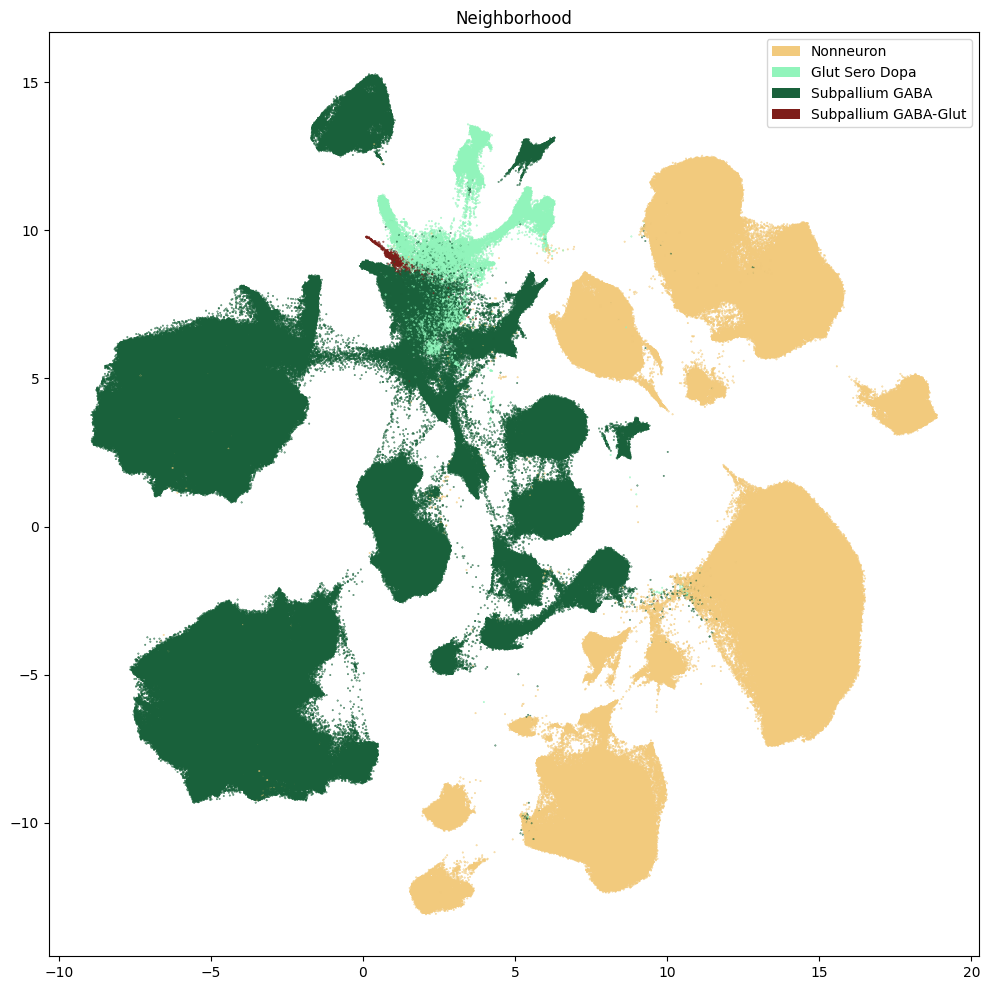

In [36]:
fig, ax = plot_umap(
    cell_with_taxonomy['x'],
    cell_with_taxonomy['y'],
    cc=cell_with_taxonomy['Neighborhood_color'],
    labels=cell_with_taxonomy['Neighborhood'],
    term_orders=cell_with_taxonomy['Neighborhood_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("Neighborhood")
plt.show()

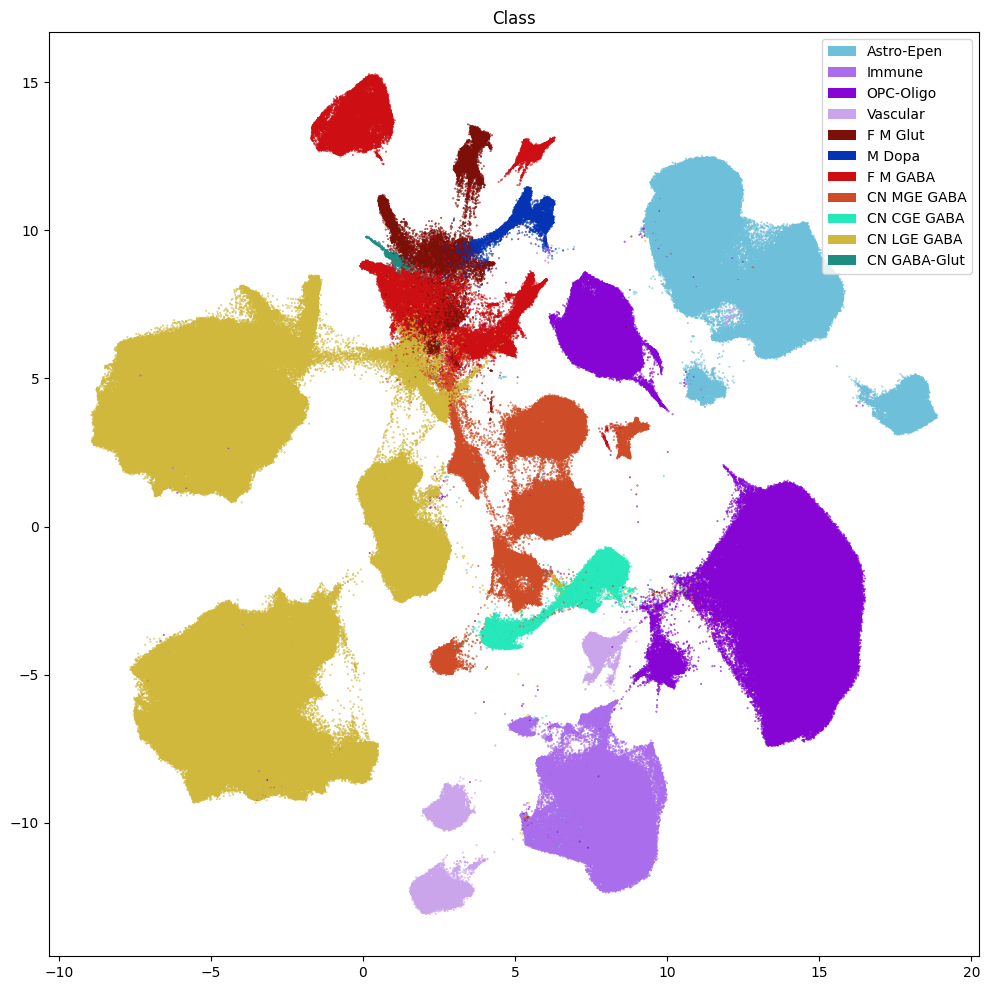

In [37]:
fig, ax = plot_umap(
    cell_with_taxonomy['x'],
    cell_with_taxonomy['y'],
    cc=cell_with_taxonomy['Class_color'],
    labels=cell_with_taxonomy['Class'],
    term_orders=cell_with_taxonomy['Class_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("Class")
plt.show()

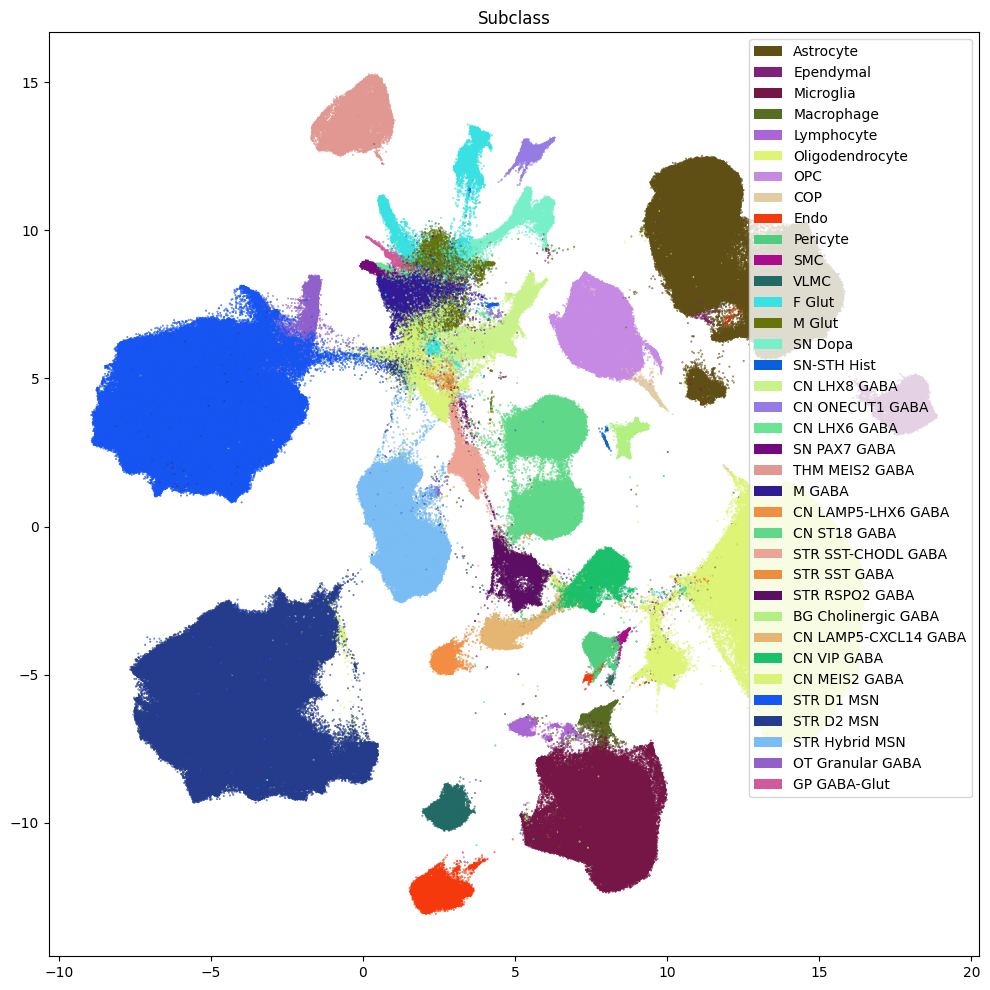

In [38]:
fig, ax = plot_umap(
    cell_with_taxonomy['x'],
    cell_with_taxonomy['y'],
    cc=cell_with_taxonomy['Subclass_color'],
    labels=cell_with_taxonomy['Subclass'],
    term_orders=cell_with_taxonomy['Subclass_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("Subclass")
plt.show()

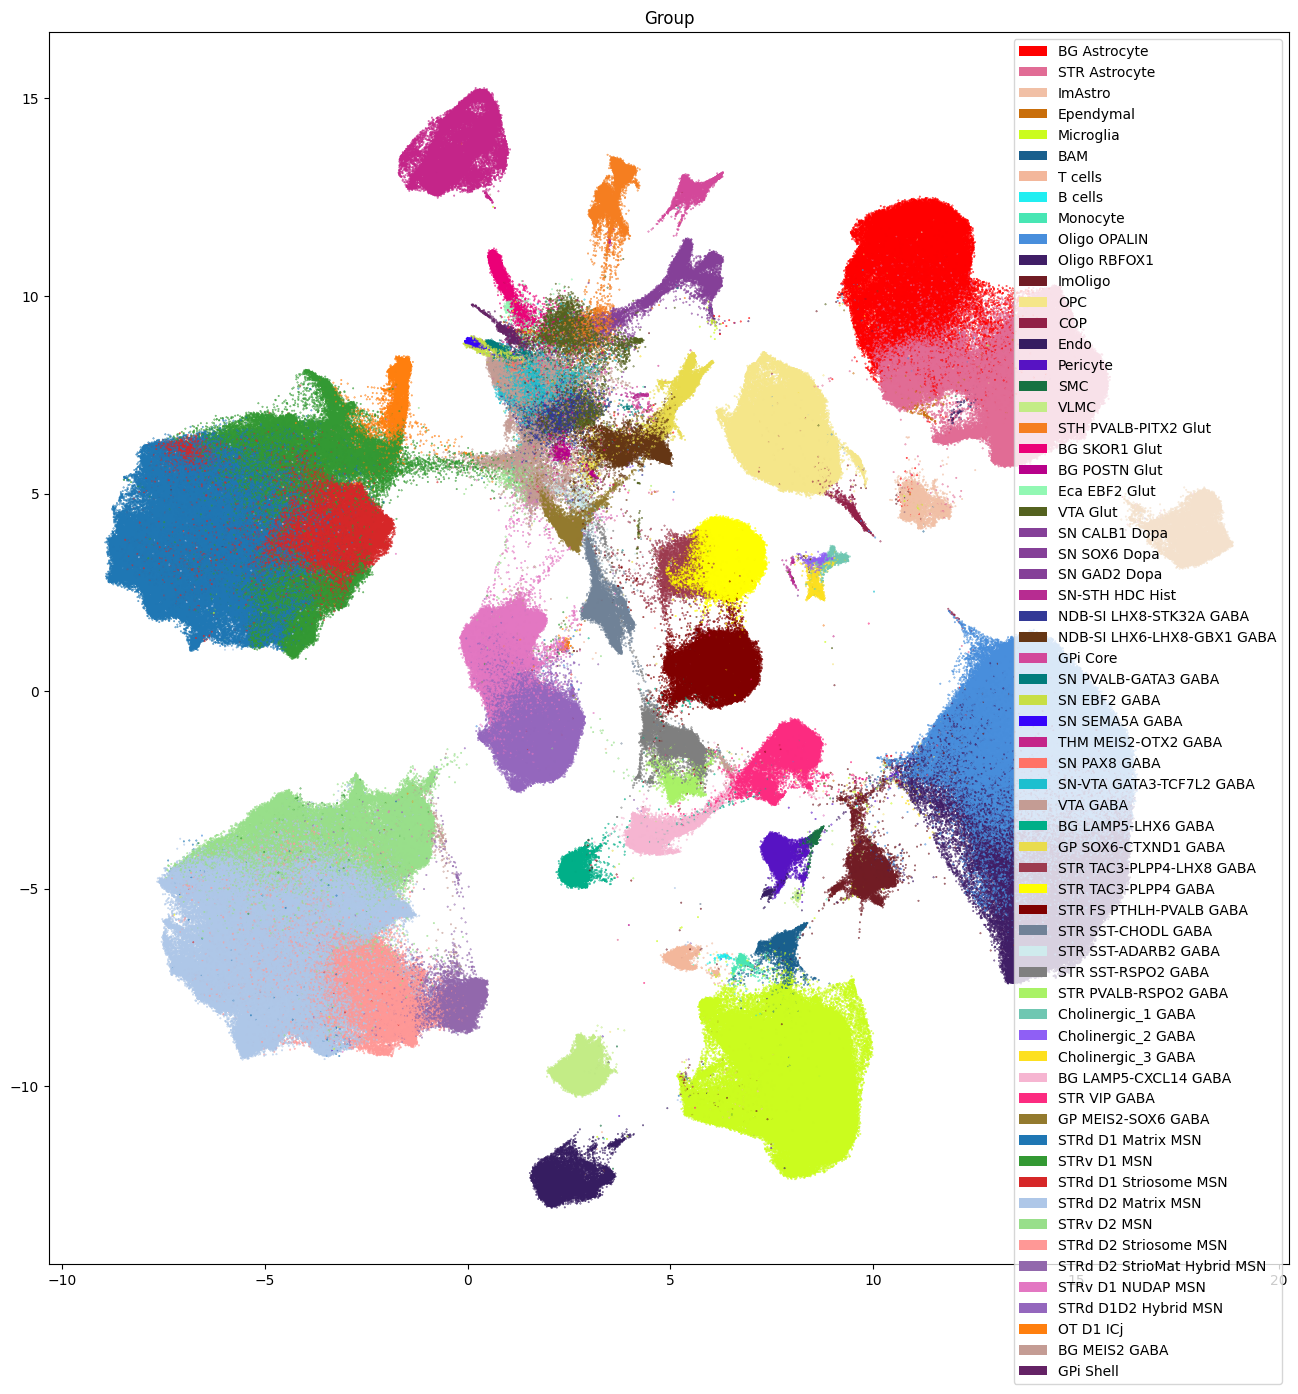

In [39]:
fig, ax = plot_umap(
    cell_with_taxonomy['x'],
    cell_with_taxonomy['y'],
    cc=cell_with_taxonomy['Group_color'],
    labels=cell_with_taxonomy['Group'],
    term_orders=cell_with_taxonomy['Group_order'],
    fig_width=16,
    fig_height=16
)
res = ax.set_title("Group")
plt.show()

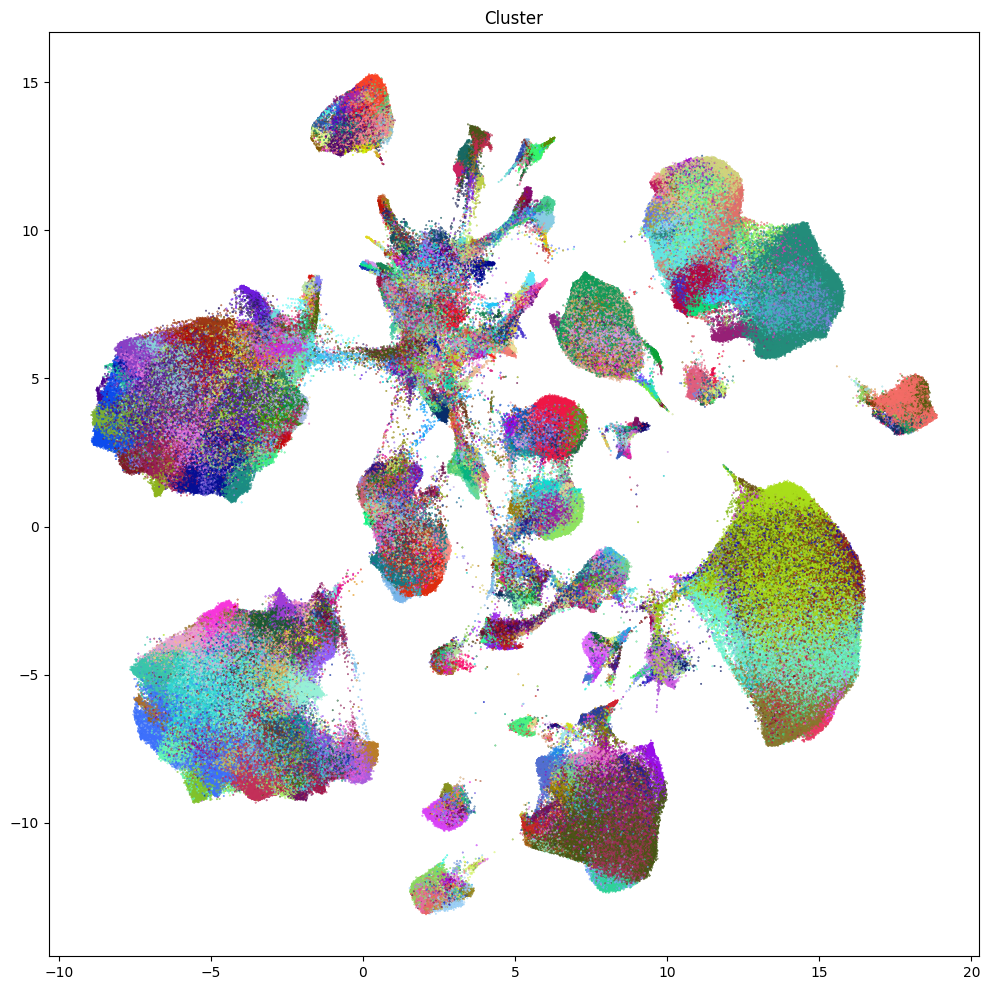

In [40]:
fig, ax = plot_umap(
    cell_with_taxonomy['x'],
    cell_with_taxonomy['y'],
    cc=cell_with_taxonomy['Cluster_color'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("Cluster")
plt.show()

### Aggregating cluster and cells counts per term

Let's investigate the taxonomy information a bit more. In this section, we'll create bar plots showing the number of clusters and cells at each level in the taxonomy. 

First, we need to compute the number of clusters that are in each of the celltype taxons above it.

In [41]:
# Count the number of clusters associated with each cluster annotation term
term_cluster_count = membership_with_cluster_info.reset_index().groupby(['cluster_annotation_term_label'])[['cluster_alias']].count()
term_cluster_count.columns = ['number_of_clusters']
term_cluster_count.head()

number_of_clusters
cluster_annotation_term_label                    
CS20250428_CLASS_0000                          86
CS20250428_CLASS_0001                         101
CS20250428_CLASS_0002                          11
CS20250428_CLASS_0003                         406
CS20250428_CLASS_0005                         189

We already have our number of cells computed previously, so we'll just use them here and cluster counts into the cluster_annotation table.

In [42]:
# Join counts with the term dataframe
term_with_counts = cluster_annotation_term_with_cells.join(term_cluster_count)
term_with_counts[['name', 'cluster_annotation_term_set_name', 'number_of_clusters', 'number_of_cells']].head(5)

name  \
cluster_annotation_term_label                         
CS20250428_NEIGH_0001                     Nonneuron   
CS20250428_NEIGH_0000                Glut Sero Dopa   
CS20250428_NEIGH_0002               Subpallium GABA   
CS20250428_NEIGH_0003          Subpallium GABA-Glut   
CS20250428_CLASS_0000                    Astro-Epen   

                              cluster_annotation_term_set_name  \
cluster_annotation_term_label                                    
CS20250428_NEIGH_0001                             Neighborhood   
CS20250428_NEIGH_0000                             Neighborhood   
CS20250428_NEIGH_0002                             Neighborhood   
CS20250428_NEIGH_0003                             Neighborhood   
CS20250428_CLASS_0000                                    Class   

                               number_of_clusters  number_of_cells  
cluster_annotation_term_label                                       
CS20250428_NEIGH_0001                         295           815521  
CS20250428_NEIGH_0000                         114            29574  
CS20250428_NEIGH_0002                         924          1051965  
CS20250428_NEIGH_0003                          11             1021  
CS20250428_CLASS_0000                          86           224824

Below we create a function to plot the cluster and cell counts in a bar graph, coloring by the associated taxon level.

In [43]:
def bar_plot_by_level_and_type(df, level, fig_width = 8.5, fig_height = 4):
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(fig_width, fig_height)
    
    for idx, ctype in enumerate(['clusters', 'cells']):

        pred = (df['cluster_annotation_term_set_name'] == level)
        names = df[pred]['name']
        counts = df[pred]['number_of_%s' % ctype]
        colors = df[pred]['color_hex_triplet']
        
        ax[idx].barh(names, counts, color=colors)
        ax[idx].set_title('Number of %s by %s' % (ctype,level)),
        ax[idx].set_xscale('log')
        
        if idx > 0:
            ax[idx].set_yticklabels([])

    plt.show()

Now let's plot the counts for each of the taxonomy levels above Cluster.

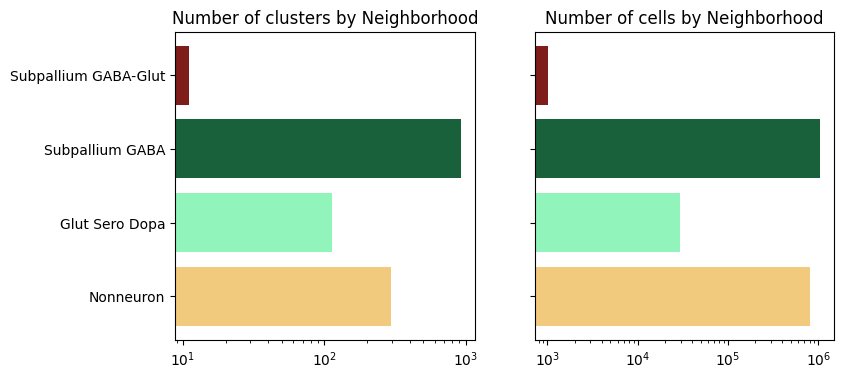

In [44]:
bar_plot_by_level_and_type(term_with_counts, 'Neighborhood')
plt.show()

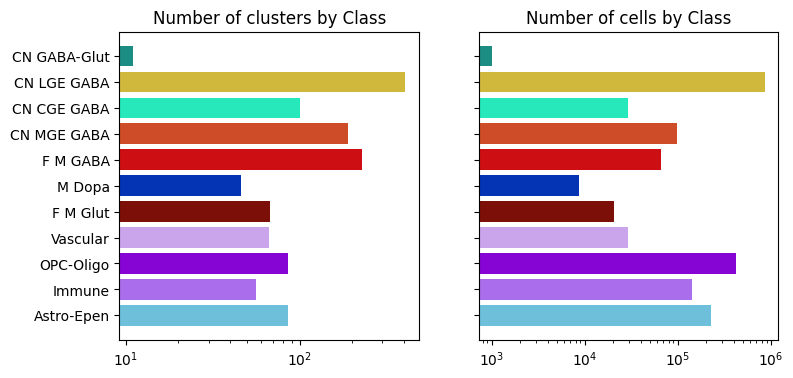

In [45]:
bar_plot_by_level_and_type(term_with_counts, 'Class')
plt.show()

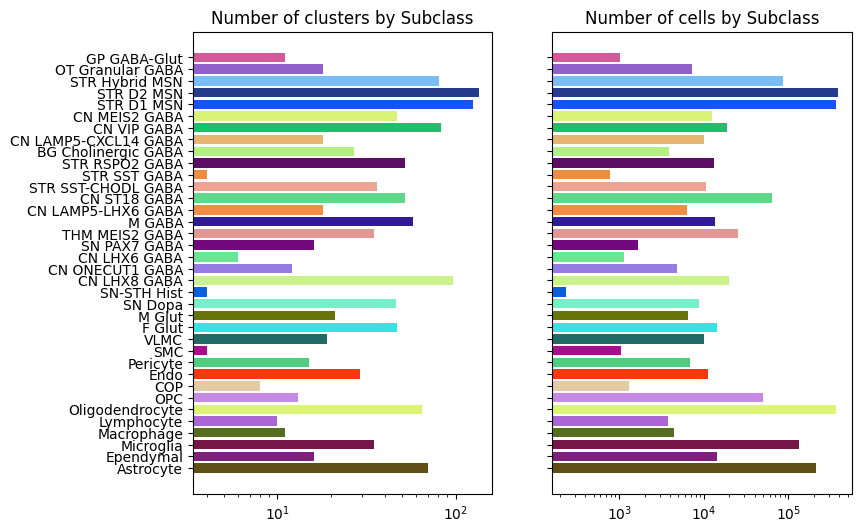

In [46]:
bar_plot_by_level_and_type(term_with_counts, 'Subclass', 8.5, 6)
plt.show()

In [47]:
term_with_counts[pd.isna(term_with_counts['number_of_cells'])]

Empty DataFrame
Columns: [name, cluster_annotation_term_set_label, cluster_annotation_term_set_name, color_hex_triplet, term_order, term_set_order, parent_term_label, parent_term_name, parent_term_set_label, cluster_alias, number_of_cells, number_of_clusters]
Index: []

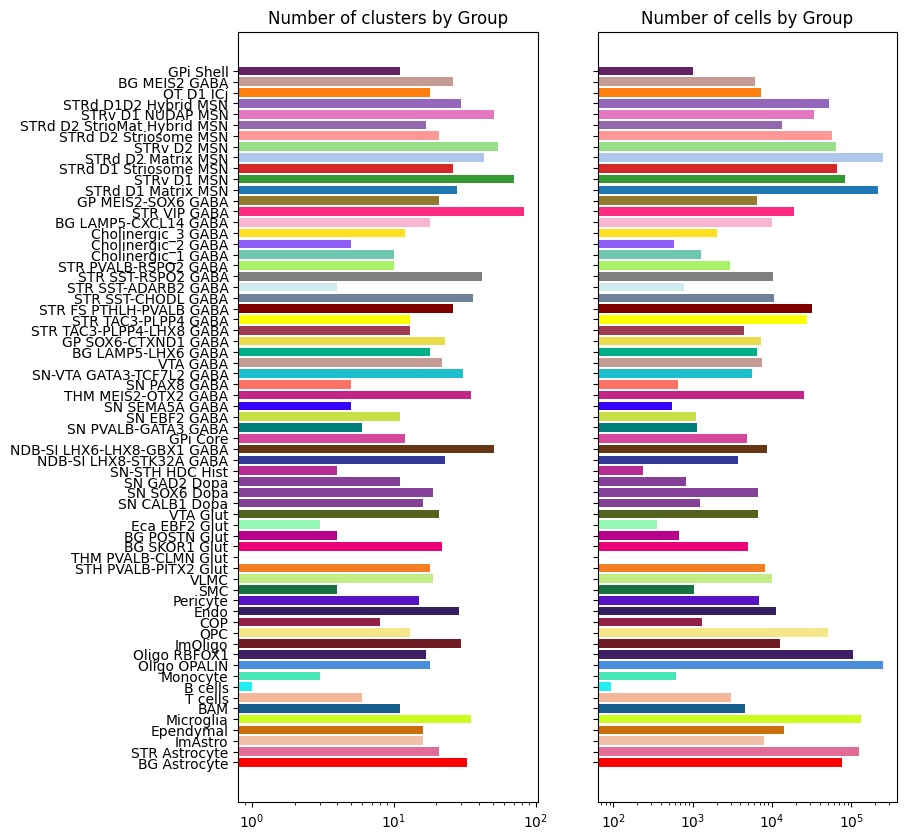

In [48]:
bar_plot_by_level_and_type(term_with_counts, 'Group', 8.5, 10)
plt.show()

#### Distribution of lower taxonomy levels in their parents.

We can also use a similar visualization to show a given taxonomy level in another. Below we define functions to manipulate our data and plot the stacked bar plot.

In [49]:
def distribution(A, B):
    
    AxB = cluster_details.groupby([A, B])[['Cluster']].count()
    AxB.columns = ['number_of_clusters']
    AxB = AxB.unstack().fillna(0)

    B_names = [x[1] for x in list(AxB.columns)]
    pred = (cluster_annotation_term_with_cells['cluster_annotation_term_set_name'] == B)
    term_by_name = cluster_annotation_term_with_cells[pred].set_index('name')
    B_colors = term_by_name.loc[B_names, 'color_hex_triplet']
    
    return AxB, B_names, B_colors

In [50]:
def stacked_bar_distribution(AxB, B_names, B_colors, fig_width = 6, fig_height = 6):

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    bottom = np.zeros(len(AxB))

    for i, col in enumerate(AxB.columns):
        ax.barh(AxB.index, AxB[col], left=bottom, label=col[1], color=B_colors[i])
        bottom += np.array(AxB[col])

    ax.set_title('Distribution of %s in each %s' % (AxB.columns.names[1], AxB.index.name))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    
    return fig, ax

We can now visualize how each lower level in the taxonomy is distributed by cluster in the upper portions of the taxonomy.

/tmp/ipykernel_10956/1772253940.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.barh(AxB.index, AxB[col], left=bottom, label=col[1], color=B_colors[i])


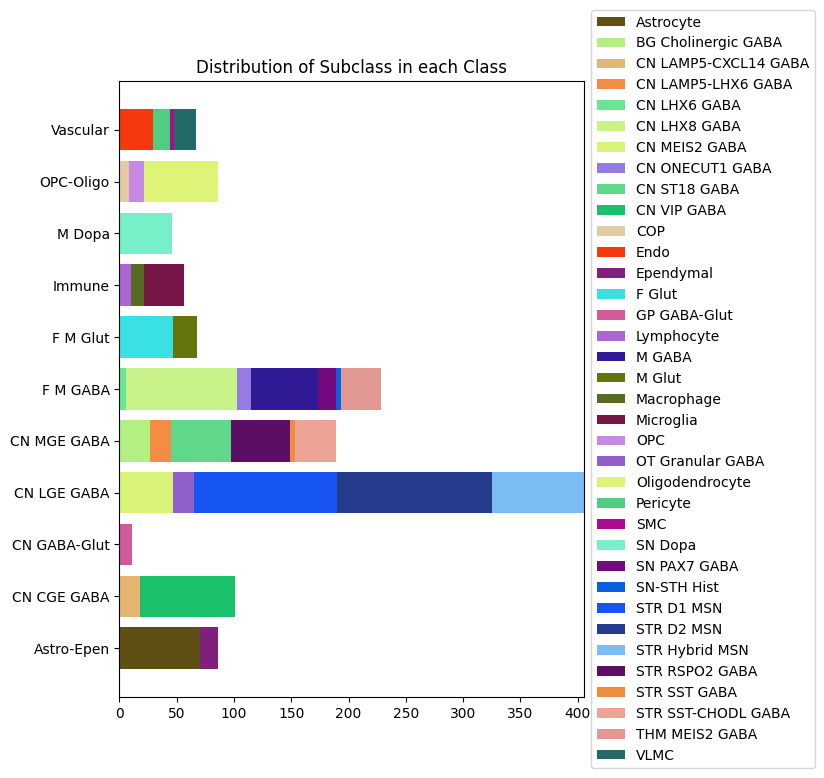

In [51]:
AxB, B_names, B_colors = distribution('Class', 'Subclass')
fig, ax = stacked_bar_distribution(AxB, B_names, B_colors, 6, 8)
plt.show()

### Visualizing the human whole brain taxonomy

Term sets: Class, Subclasss, Group and Cluster forms a four level Basil Ganglia taxonomy. We can visualize the taxonomy as a sunburst diagram that shows the single inheritance hierarchy through a series of rings, that are sliced for each annotation term. Each ring corresponds to a level in the hierarchy. We have ordered the rings so that the Class level is the outer most ring so that we can add in labels. Rings are sliced up and divided based on their hierarchical relationship to the parent slice. The angle of each slice is proportional to the number of clusters belonging to the term. Note that we exlude Neighborhood here as it is a much less interesting plot.

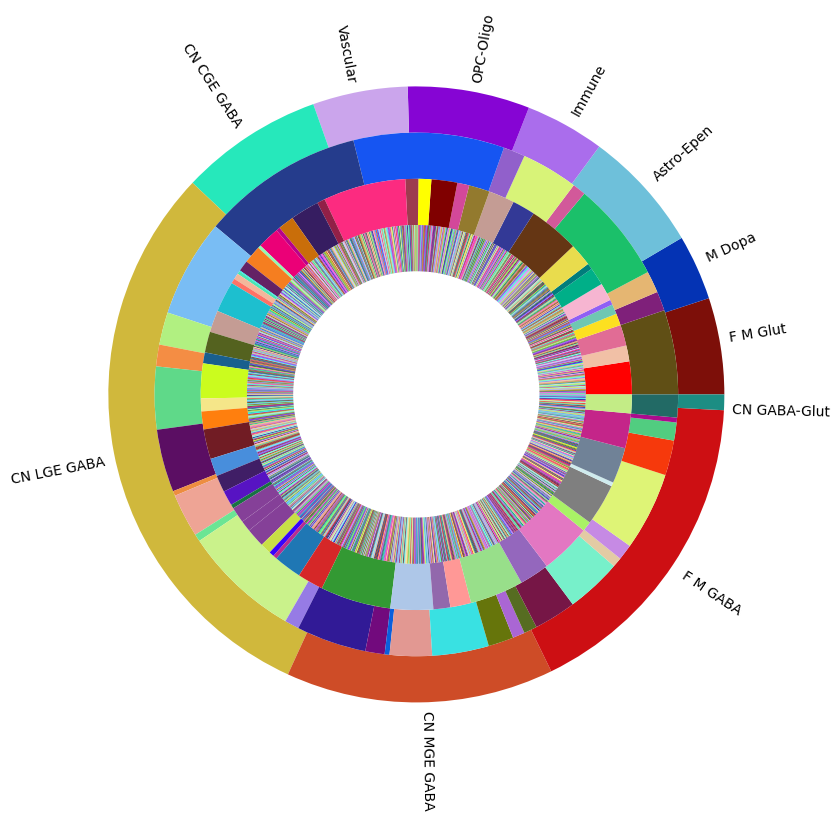

In [52]:
levels = ['Class', 'Subclass', 'Group', 'Cluster']
df = {}

reset_term_with_counts = term_with_counts.reset_index()
for lvl in levels :
    pred = reset_term_with_counts['cluster_annotation_term_set_name'] == lvl
    df[lvl] = reset_term_with_counts[pred]
    df[lvl] = df[lvl].sort_values(['parent_term_label', 'cluster_annotation_term_label'])

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
size = 0.15

for i, lvl in enumerate(levels):
    
    if lvl == 'Class':
        ax.pie(df[lvl]['number_of_clusters'],
               colors=df[lvl]['color_hex_triplet'],
               labels = df[lvl]['name'],
               rotatelabels=True,
               labeldistance=1.025,
               radius=1,
               wedgeprops=dict(width=size, edgecolor=None),
               startangle=0)
    else :
        ax.pie(df[lvl]['number_of_clusters'],
               colors=df[lvl]['color_hex_triplet'],
               radius=1-i*size,
               wedgeprops=dict(width=size, edgecolor=None),
               startangle=0)

plt.show()